<a href="https://colab.research.google.com/github/LizCarter492/EnvDatSci/blob/main/CodeSprints/FeatureDependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Feature Dependence and Regression Analysis
In this example, we will be using a spatial dataset of county-level election and demographic statistics for the United States. We'll explore different methods to diagnose and account for multicollinearity in our data in regression analysis. Specifically, we'll calculate variance inflation factor (VIF), and compare parameter estimates and model fit in a multivariate regression predicting 2016 county voting preferences using an OLS model, a ridge regression, a lasso regression, and an elastic net regression.

Objectives:
* **Calculate a variance inflation factor to diagnose multicollinearity.**
* **Interpret model summary statistics.**
* **Describe how multicollinearity impacts stability in parameter esimates.**
* **Explain the variance/bias tradeoff and describe how to use it to improve models**
* **Draw a conclusion based on contrasting models.**



In [2]:
%%capture
!pip install geopandas
!pip install libpysal

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute
from libpysal.weights.contiguity import Queen
import libpysal
from statsmodels.api import OLS
sns.set_style('white')

First, we're going to load the 'Elections' dataset from the libpysal library, which is a very easy to use API that accesses the Geodata Center at the University of Chicago.

* More on spatial data science resources from UC: https://spatial.uchicago.edu/
* A list of datasets available through lipysal: https://geodacenter.github.io/data-and-lab//

In [2]:
from libpysal.examples import load_example
elections = load_example('Elections')
#note the folder where your data now lives:


In [3]:
#First, let's see what files are available in the 'Elections' data example
elections.get_file_list()

['/Users/liamhawes/Library/Application Support/pysal/Elections/__MACOSX/election/._election.shp',
 '/Users/liamhawes/Library/Application Support/pysal/Elections/election/election.prj',
 '/Users/liamhawes/Library/Application Support/pysal/Elections/election/election.shx',
 '/Users/liamhawes/Library/Application Support/pysal/Elections/election/election.shp',
 '/Users/liamhawes/Library/Application Support/pysal/Elections/election/election.dbf']

When you are out in the world doing research, you often will not find a ready-made function to download your data. That's okay! You know how to get this dataset without using pysal! Do a quick internal review of online data formats and automatic data downloads.

### TASK 1: Use urllib functions to download this file directly from the internet a folder (not in your git repository). Extract the zipped file you've downloaded into a subfolder called elections.

In [2]:
# Task 1 code here:
import urllib.request

def download_file(url, save_path):
    try:
        urllib.request.urlretrieve(url, save_path)
        print(f"File downloaded successfully and saved to: {save_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# URL of the file
url = "https://geodacenter.github.io/data-and-lab/data/election.zip"

# Specify the path where you want to save the file
save_path = "/Users/liamhawes/Documents/college/Grad/2 Envi Data Science/election_data/election.zip"

# Call the download function
download_file(url, save_path)


import zipfile
import os

def extract_zip(zip_file_path, extract_to_folder):
    try:
        # Ensure the extraction folder exists
        os.makedirs(extract_to_folder, exist_ok=True)

        # Extract all the contents of the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_folder)
        
        print(f"Contents extracted successfully to: {extract_to_folder}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Path to the zip file
zip_file_path = "/Users/liamhawes/Documents/college/Grad/2 Envi Data Science/election_data/election.zip"

# Path where you want to extract the contents
extract_to_folder = "/Users/liamhawes/Documents/college/Grad/2 Envi Data Science/election_data/elections"

# Call the extraction function
extract_zip(zip_file_path, extract_to_folder)

Contents extracted successfully to: /Users/liamhawes/Documents/college/Grad/2 Envi Data Science/election_data/elections


### TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"

In [3]:
# TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"

# Define the file path
file_path = "/Users/liamhawes/Documents/college/Grad/2 Envi Data Science/election_data/elections/election/election.shp"

# Read the shapefile into a GeoDataFrame
votes = gpd.read_file(file_path)

# Display the first few rows of the dataframe
print(votes.head())

  STATEFP COUNTYFP  GEOID         ALAND      AWATER       area_name  \
0      01      005  01005  2.291821e+09  50864677.0  Barbour County   
1      01      023  01023  2.365955e+09  19059247.0  Choctaw County   
2      01      035  01035  2.201896e+09   6643480.0  Conecuh County   
3      01      051  01051  1.601877e+09  99850740.0   Elmore County   
4      01      065  01065  1.667805e+09  32525874.0     Hale County   

  state_abbr  PST045214  PST040210  PST120214  ...  total_2012  Demvotes12  \
0         AL    26887.0    27457.0       -2.1  ...     11459.0      5873.0   
1         AL    13323.0    13858.0       -3.9  ...      7965.0      3785.0   
2         AL    12670.0    13228.0       -4.2  ...      7013.0      3551.0   
3         AL    80977.0    79296.0        2.1  ...     35440.0      8940.0   
4         AL    15184.0    15760.0       -3.7  ...      8628.0      5401.0   

   GOPvotes12  county_fip  state_fips  pct_dem_12  pct_gop_12  diff_2012  \
0      5539.0         5.0   

<Axes: >

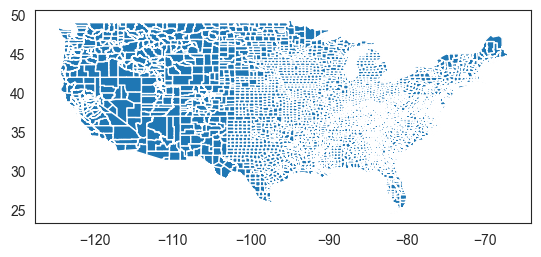

In [4]:
#Let's view the shapefile to get a general idea of the geometry we're looking at:
%matplotlib inline
votes.plot()

In [5]:
#View the first few lines of the dataset
votes.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,total_2012,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry
0,01,005,01005,2.291821e+09,50864677.0,Barbour County,AL,26887.0,27457.0,-2.1,...,11459.0,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.748 31.619, -85.745 31.619, -85...."
1,01,023,01023,2.365955e+09,19059247.0,Choctaw County,AL,13323.0,13858.0,-3.9,...,7965.0,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.473 31.894, -88.469 31.93, -88.4..."
2,01,035,01035,2.201896e+09,6643480.0,Conecuh County,AL,12670.0,13228.0,-4.2,...,7013.0,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.427 31.264, -87.426 31.268, -87...."
3,01,051,01051,1.601877e+09,99850740.0,Elmore County,AL,80977.0,79296.0,2.1,...,35440.0,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.413 32.751, -86.371 32.751, -86...."
4,01,065,01065,1.667805e+09,32525874.0,Hale County,AL,15184.0,15760.0,-3.7,...,8628.0,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.87 32.762, -87.868 32.766, -87.8..."


In [6]:
#Since there are too many columns for us to view on a signle page using "head", we can just print out the column names so we have them all listed for reference
for col in votes.columns:
    print(col)

STATEFP
COUNTYFP
GEOID
ALAND
AWATER
area_name
state_abbr
PST045214
PST040210
PST120214
POP010210
AGE135214
AGE295214
AGE775214
SEX255214
RHI125214
RHI225214
RHI325214
RHI425214
RHI525214
RHI625214
RHI725214
RHI825214
POP715213
POP645213
POP815213
EDU635213
EDU685213
VET605213
LFE305213
HSG010214
HSG445213
HSG096213
HSG495213
HSD410213
HSD310213
INC910213
INC110213
PVY020213
BZA010213
BZA110213
BZA115213
NES010213
SBO001207
SBO315207
SBO115207
SBO215207
SBO515207
SBO415207
SBO015207
MAN450207
WTN220207
RTN130207
RTN131207
AFN120207
BPS030214
LND110210
POP060210
Demvotes16
GOPvotes16
total_2016
pct_dem_16
pct_gop_16
diff_2016
pct_pt_16
total_2012
Demvotes12
GOPvotes12
county_fip
state_fips
pct_dem_12
pct_gop_12
diff_2012
pct_pt_12
geometry


#### You can use pandas summary statistics to get an idea of how county-level data varies across the United States.
### TASK 3: For example, how did the county mean percent Democratic vote change between 2012 (pct_dem_12) and 2016 (pct_dem_16)?

Look here for more info on pandas dataframes:

https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/pandas-dataframes/run-calculations-summary-statistics-pandas-dataframes/

In [8]:
#Task 3
# Display the first 5 rows of 'pct_dem_12' and 'pct_dem_16' columns
print(votes[['pct_dem_12', 'pct_dem_16']].head())

# Calculate the mean percent vote for 'pct_dem_12' and 'pct_dem_16'
mean_pct_dem_12 = votes['pct_dem_12'].mean()
mean_pct_dem_16 = votes['pct_dem_16'].mean()

# Calculate the difference in mean percent vote between 2012 and 2016
mean_difference = mean_pct_dem_16 - mean_pct_dem_12

# Display the results
print("Mean % vote in 2012:", mean_pct_dem_12)
print("Mean % vote in 2016:", mean_pct_dem_16)
print("Difference in mean % vote:", mean_difference)

   pct_dem_12  pct_dem_16
0    0.512523    0.466603
1    0.475204    0.427766
2    0.506345    0.469051
3    0.252257    0.228587
4    0.625985    0.595755
Mean % vote in 2012: 0.384501897042471
Mean % vote in 2016: 0.31666743004440157
Difference in mean % vote: -0.06783446699806944


We can also plot histograms of the data. Below, smoothed histograms from the seaborn package (imported as sns) let us get an idea of the distribution of percent democratic votes in 2012 (left) and 2016 (right).

/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/393966224.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/393966224.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])


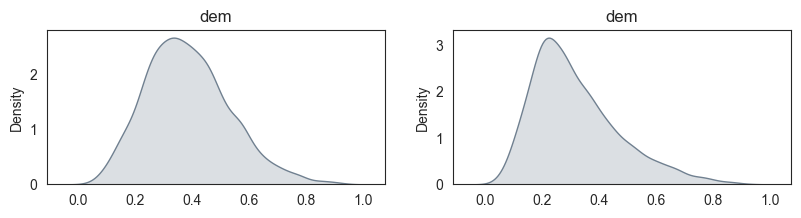

In [9]:
# Plot histograms:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
    ax[i].set_title(col.split('_')[1])

/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/3954375980.py:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/3954375980.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/3954375980.py:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
/var/folders/w_/9_r8xct13q37

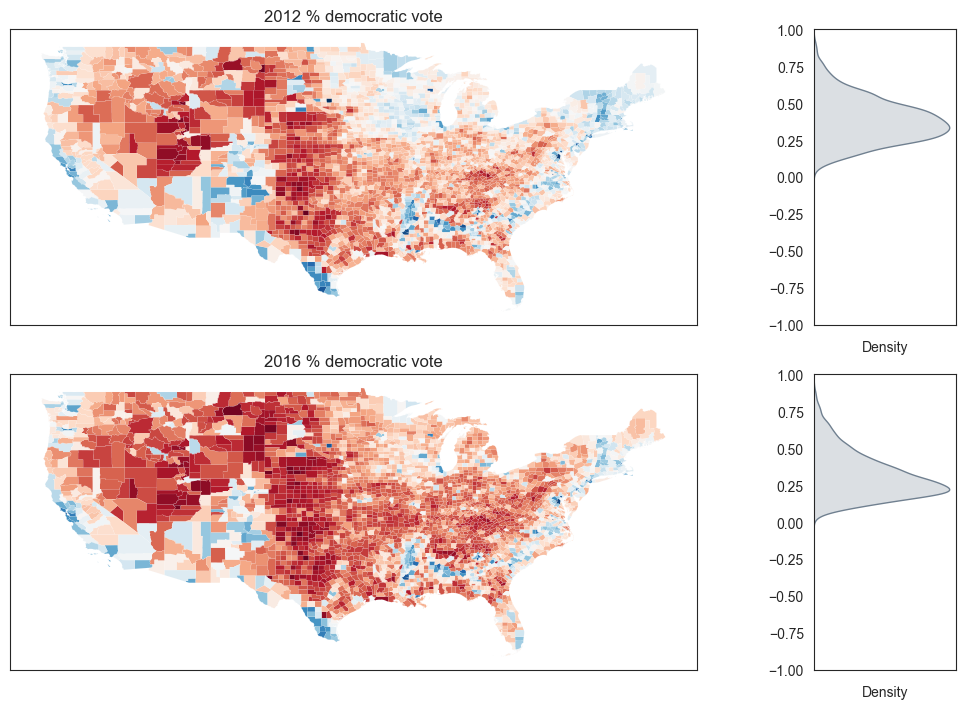

In [10]:
# Plot spatial distribution of # dem vote in 2012 and 2016 with histogram.
f,ax = plt.subplots(2,2, figsize=(1.6*6 + 1,2.4*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    ax[i,0].set_title(['2012','2016'][i] + " % democratic vote")
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

### TASK 4: Make a new column on your geopandas dataframe called "pct_dem_change" and plot it using the syntax above. Explain the plot.

In [11]:
# Task 4: add new column pct_dem_change to votes:
# Create a new column 'pct_dem_diff' that is the difference between 'pct_dem_16' and 'pct_dem_12'
votes['pct_dem_diff'] = votes['pct_dem_16'] - votes['pct_dem_12']

# Display the first few rows to confirm the new column
print(votes[['pct_dem_12', 'pct_dem_16', 'pct_dem_diff']].head())

   pct_dem_12  pct_dem_16  pct_dem_diff
0    0.512523    0.466603     -0.045920
1    0.475204    0.427766     -0.047438
2    0.506345    0.469051     -0.037294
3    0.252257    0.228587     -0.023670
4    0.625985    0.595755     -0.030230


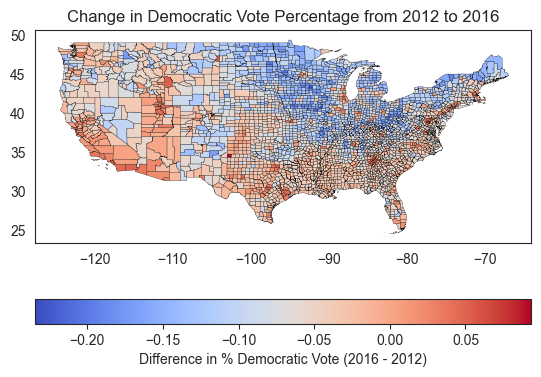

In [13]:
#Task 4: plot your pct_dem_change variable on a map:

# Plot spatial distribution of # dem vote in 2012 and 2016 with histogram.
# f,ax = plt.subplots(2,2, figsize=(1.6*6 + 1,2.4*3), gridspec_kw=dict(width_ratios=(6,1)))

# Plot the 'pct_dem_diff' column on a map with thinner boundaries
votes.plot(column='pct_dem_diff', cmap='coolwarm', legend=True,
           legend_kwds={'label': "Difference in % Democratic Vote (2016 - 2012)",
                        'orientation': "horizontal"},
           linewidth=0.2, edgecolor='black')  # Adjust linewidth here

# Set the title and show the plot
plt.title("Change in Democratic Vote Percentage from 2012 to 2016")
plt.show()

Click on this url to learn more about the variables in this dataset: https://geodacenter.github.io/data-and-lab//county_election_2012_2016-variables/

Let's say we want to learn more about what county-level factors influence percent change in democratic vote between (pct_dem_change).

There are two types of multicollinearity:

* *Intrinsic multicollinearity:* is an artifact of how we make observations. Often our measurements serve as proxies for some latent process (for example, we can measure percent silt, percent sand, and percent clay as proxies for the latent variable of soil texture). There will be slight variability in the information content between each proxy measurement, but they will not be independent of one another.

* *Incidental collinearity:* is an artifact of how we sample complex populations. If we collect data from a subsample of the landscape where we don't see all combinations of our predictor variables (do not have good cross replication across our variables). We often induce collinearity in our data just because we are limitted in our ability to sample the environment at the scale of temporal/spatial variability of our process of interest. Incidental collinearity is a model formulation problem.(See here for more info on how to avoid it: https://people.umass.edu/sdestef/NRC%20601/StudyDesignConcepts.pdf)

### TASK 5: Looking at the data description, pick two variables that you believe will be intrinsically multicollinear. List and describe these variables. Why do you think they are intrinsically related?

Demvotes16 and total_2016. Demvotes16 is the total number of Dem Votes. total_2016 is the total number of votes for 2016. Demvotes16 is a part of total_2016, making them intrensicly related

## Multivariate regression in observational data:
Our next step is to formulate our predictive/diagnostic model. We want to create a subset of the "votes" geopandas data frame that contains ten predictor variables and our response variable (pct_pt_16) two variables you selected under TASK 1. First, create a list of the variables you'd like to select.

### TASK 6: Create a subset of votes called "my_list" containing only your selected predictor variables. Make sure you use the two variables selected under TASK 5, and eight additional variables

In [19]:
# Task 4: create a subset of votes called "my list" with all your subset variables.
#my_list = ["pct_pt_16", <list your variables here>]

#For example:
my_list = ["pct_dem_diff", #The number in diff_2016 expressed as a percent of the total votes. Negative if fewer votes were cast for the Democratic candidate
           "Demvotes16", #
           "total_2016", #
           "RHI125214", #White alone, percent, 2014
           "RHI225214", #Black or African American alone, percent, 2014
           "EDU685213", #Bachelor’s degree or higher, percent of persons age 25+, 2009-2013
           "VET605213", #Veterans, 2009-2013
           "HSG495213", #Median value of owner-occupied housing units, 2009-2013
           "HSD310213", #Persons per household, 2009-2013
           "INC910213", #Per capita money income in past 12 months (2013 dollars), 2009-2013
           "LND110210"] #Land area in square miles, 2010



In [20]:
#check to make sure all your columns are there:
votes[my_list].head()

,pct_dem_diff,Demvotes16,total_2016,RHI125214,RHI225214,EDU685213,VET605213,HSG495213,HSD310213,INC910213,LND110210
0,-0.045920,4848.0,10390.0,50.2,47.6,13.4,2120.0,89200.0,2.66,16829.0,884.88
1,-0.047438,3109.0,7268.0,56.6,42.4,11.8,938.0,58200.0,2.45,20323.0,913.50
2,-0.037294,3069.0,6543.0,52.1,46.2,8.8,1101.0,69600.0,2.61,15605.0,850.16
3,-0.023670,8436.0,36905.0,76.0,21.2,21.0,8364.0,144600.0,2.62,23856.0,618.49
4,-0.030230,4772.0,8010.0,40.8,58.1,12.8,995.0,79900.0,2.56,18812.0,643.94


### Scatterplot matrix
We call the process of getting to know your data (ranges and distributions of the data, as well as any relationships between variables) "exploratory data analysis". Pairwise plots of your variables, called scatterplots, can provide a lot of insight into the type of relationships you have between variables. A scatterplot matrix is a pairwise comparison of all variables in your dataset.

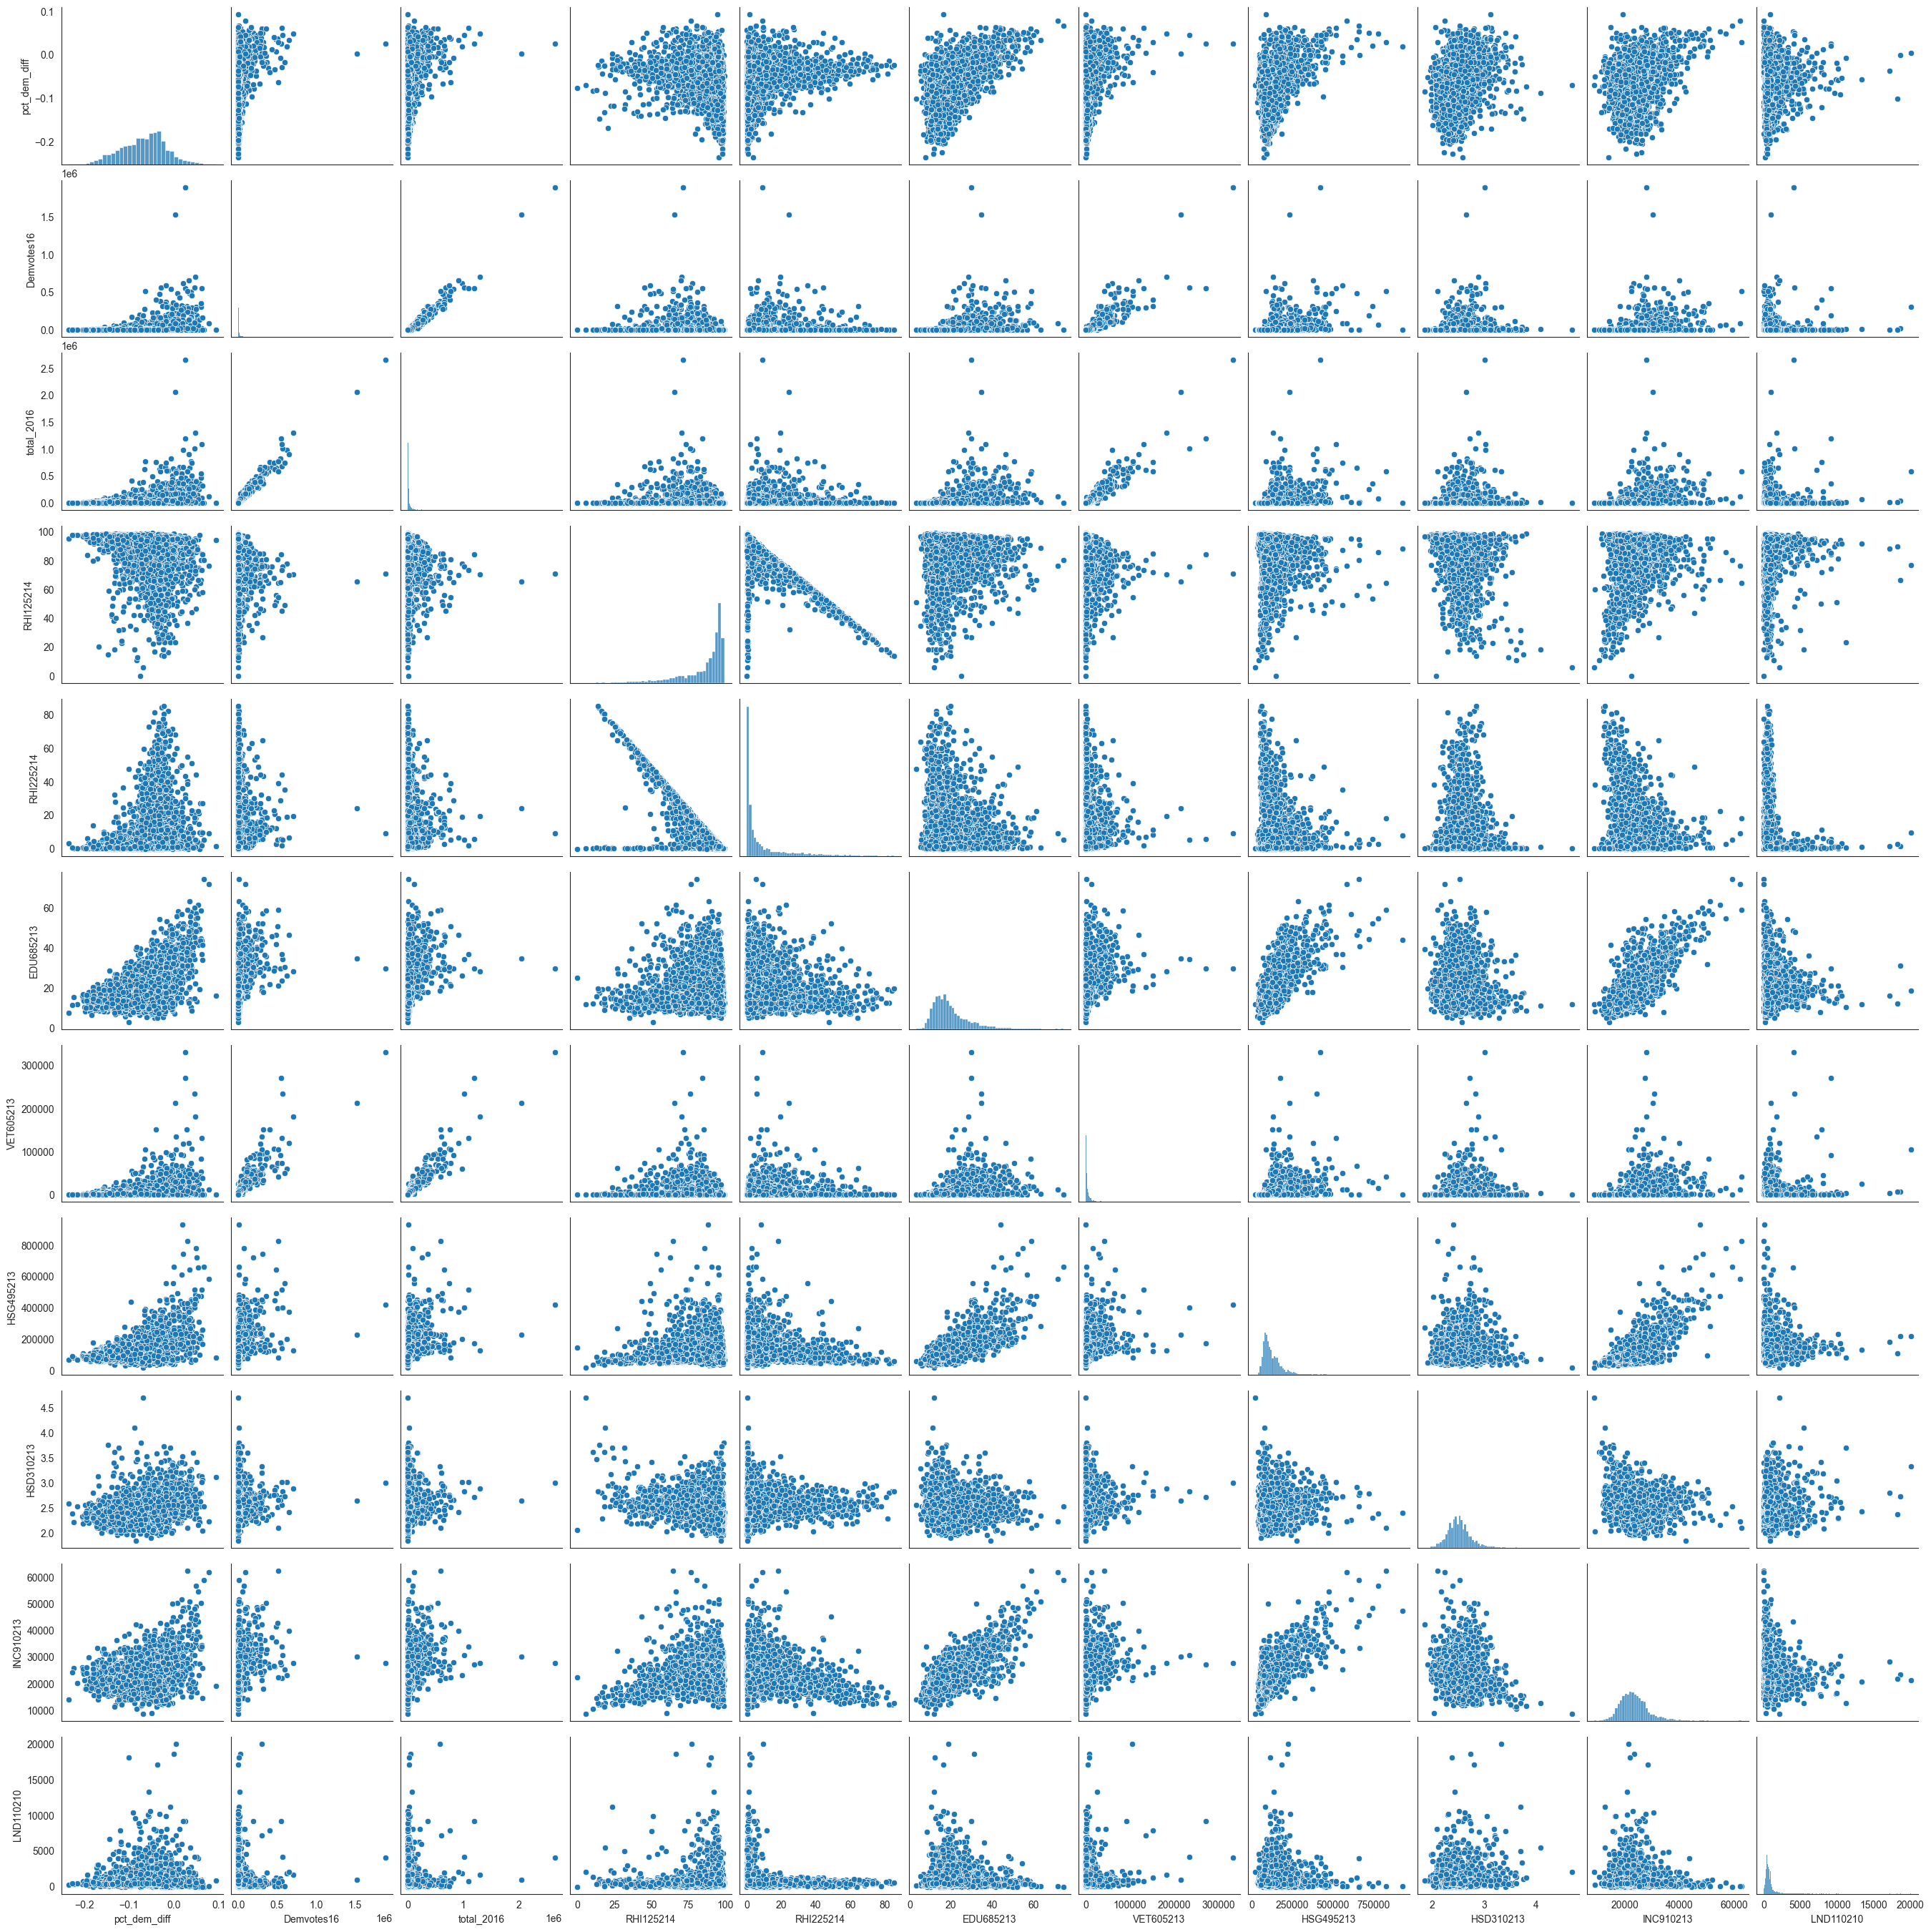

In [21]:
#Use seaborn.pairplot to plot a scatterplot matrix of you 10 variable subset:
sns.pairplot(votes[my_list])

### TASK 7: Do you observe any collinearity in this dataset? How would you describe the relationship between your two "incidentally collinear" variables that you selected based on looking at variable descriptions?

Threre is colinarity in the dataset. The 2 vars I chose are highly colinear with each other

### TASK 8: What is plotted on the diagonal panels of the scatterplot matrix?



A Histogram of the data

## Diagnosing collinearity globally:
Variance Inflation Factor describes the magnitude of variance inflation that can be expected in an OLS parameter estimate for a given variable *given pairwise collinearity between that variable and another variable*.

In [22]:
#VIF = 1/(1-R2) of a pairwise OLS regression between two predictor variables
#We can use a built-in function "variance_inflation_factor" from statsmodel.api to calculate VIF
#Learn more about the function
?variance_inflation_factor

Signature: variance_inflation_factor(exog, exog_idx)
Docstring:
Variance inflation factor, VIF, for one exogenous variable

The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.

One recommendation is that if VIF is greater than 5, then the explanatory
variable given by exog_idx is highly collinear with the other explanatory
variables, and the parameter estimates will have large standard errors
because of this.

Parameters
----------
exog : {ndarray, DataFrame}
    design matrix with all explanatory variables, as for example used in
    regression
exog_idx : int
    index of the exogenous variable in the columns of exog

Returns
-------
float
    variance inflation factor

Notes
-----
This function does not save the auxiliary regression.

See Also
--------
xxx : class for regression diagnostics

In [23]:
#Calculate VIFs on our dataset
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(votes[my_list[1:11]].values, i) for i in range(votes[my_list[1:11]].shape[1])]
vif["features"] = votes[my_list[1:11]].columns


In [24]:
vif.round()

,VIF Factor,features
0,37.0,Demvotes16
1,79.0,total_2016
2,65.0,RHI125214
3,4.0,RHI225214
4,20.0,EDU685213
5,16.0,VET605213
6,10.0,HSG495213
7,57.0,HSD310213
8,63.0,INC910213
9,2.0,LND110210


### Collinearity is always present in observational data. When is it a problem?
Generally speaking, including any variables with VIF > 10 is considered "too much" collinearity. But this value is somewhat arbitrary. The extent to which variance inflation will impact your analysis is highly context dependent. There are two primary contexts where variance inflation is problematic:

 1\. **You are using your analysis to evaluate variable importance:** If you are using parameter estimates from your model to diagnose which observations have physically important relationships with your response variable, variance inflation can make an important predictor look unimportant, and parameter estimates will be highly leveraged by small changes in the data.

 2\. **You want to use your model to make predictions in a situation where the specific structure of collinearity between variables may have shifted:** When training a model on collinear data, the model only applies to data with that exact structure of collinearity.

### Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether there is a statistically significant relationship between per capita income and percent change in democratic vote.

In [26]:
#first, forumalate the model. See weather_trend.py in "Git_101" for a refresher on how.

#extract variable that you want to use to "predict"
X = np.array(votes[my_list[1:11]].values)
#standardize data to assist in interpretation of coefficients
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

#extract variable that we want to "predict"
Y = np.array(votes['pct_dem_diff'].values)
#standardize data to assist in interpretation of coefficients
Y = (Y - np.mean(X)) / np.std(Y)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [27]:
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.169
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              62.80
Date:                Tue, 12 Nov 2024   Prob (F-statistic):                   1.31e-116
Time:                        13:55:33   Log-Likelihood:                         -5763.8
No. Observations:                3108   AIC:                                  1.155e+04
Df Residuals:                    3098   BIC:                                  1.161e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### TASK 9: Answer: which coefficients indicate a statisticall significant relationship between parameter and pct_dem_change? What is your most important predictor variable? How can you tell?


x3             0.2491      0.065      3.856      0.000       0.122       0.376
x4             0.5480      0.063      8.766      0.000       0.425       0.671
x5             0.5657      0.051     11.180      0.000       0.466       0.665
x8             0.3087      0.032      9.606      0.000       0.246       0.372
x9            -0.1170      0.052     -2.235      0.025      -0.220      -0.014
x10            0.1141      0.030      3.846      0.000       0.056       0.172

Demvotes16

2	65.0	RHI125214
3	4.0	RHI225214
4	20.0	EDU685213
7	57.0	HSD310213
8	63.0	INC910213
9	2.0	LND110210

x4 or RHI225214 most important because greatest coefficient

### TASK10:  Are any of these parameters subject to variance inflation? How can you tell?


**With a cutoff of VIF=10, the following variables are subject to variable inflation.**

	269.0 	SEX255214
	119.0 	RHI125214
	20.0 	EDU685213
	11.0 	HSG495213
	106.0 	HSD310213
	67.0 	INC910213

	All of them Are greater that 10


LND110210
RHI225214
HSG495213
are 10 or less


Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values

In [28]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=OLS(Y,X).fit().resid


In [29]:
vif['OLS_coef']=OLS(Y,X).fit().params

/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/1902177926.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


<Axes: ylabel='Density'>

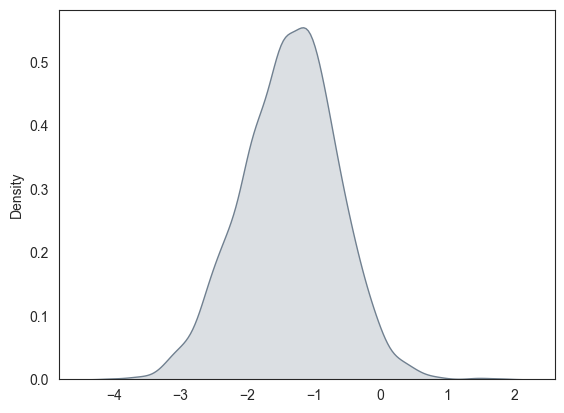

In [30]:
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


### TASK 11: Are our residuals normally distributed with a mean of zero? What does that mean?



The mean is not zero but the distrubution does appear normal. The model is overrepresenting the data

## Penalized regression: ridge penalty
In penalized regression, we intentionally bias the parameter estimates to stabilize them given collinearity in the dataset.

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

>As mentioned before, ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

**Objective = RSS + α * (sum of square of coefficients)**

Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

* **α = 0:** The objective becomes same as simple linear regression. We’ll get the same coefficients as simple linear regression.

* **α = ∞:** The coefficients will approach zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.

* **0 < α < ∞:** The magnitude of α will decide the weightage given to different parts of objective. The coefficients will be somewhere between 0 and ones for simple linear regression."

In other words, the ridge penalty shrinks coefficients such that collinear coefficients will have more similar coefficient values. It has a "grouping" tendency.

In [31]:
# when L2=0, Ridge equals OLS
model = Ridge(alpha=1)

In [32]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.573 (0.017)


In [33]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)


[-0.14347581  0.17066052  0.24774772  0.54666534  0.56507278  0.01695382
  0.05058244  0.30860216 -0.11644457  0.11387096]


### Hyperparameter tuning
The L2 coefficient (called alpha above) is a free parameter (hyperparameter) in the model, meaning we can set it whatever value we feel is best.

In machine learning, we often try multiple options for these hyperparameters, and select the value with the highest model performance.

In [34]:
# Train on a range of alphas
alpha = np.arange(0,20,0.1)
ridge_tune=pd.DataFrame(alpha, columns=["alpha"])
ridge_tune['Score']=0
i=0
for a in alpha:
  model= Ridge(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  ridge_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/3357503210.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ridge_tune.Score.loc[i]=mean(oos_scores)
/var/folders/w_/9_r8xct13q37vqlk_m2dxxxc0000gn/T/ipykernel_9764/3357503210.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5726855547500129' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ridge_tune.Score.loc[i]=mean(oos_scores)


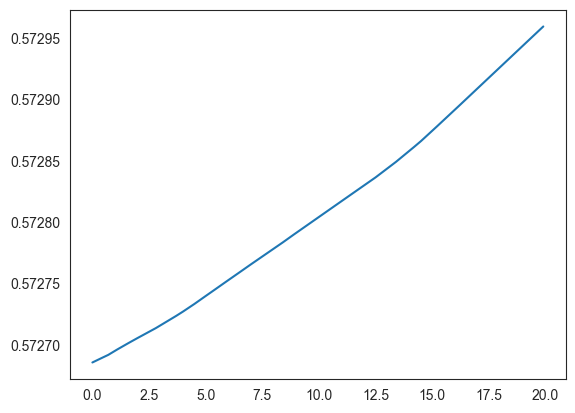

In [35]:
#  Plot model performance as a function of alpha
plt.plot(ridge_tune.alpha, ridge_tune.Score)
plt.show()
# What is the y-axis label? What is the x-axis label?

In [36]:
# Select the value of alpha which minimizes MAE
a2 = ridge_tune.alpha.iloc[ridge_tune['Score'].idxmin()]
a2

0.0

In [37]:
# Train model with optimized alpha
model = Ridge(alpha=a2)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
vif['Ridge_coef']=model.coef_

[-0.14694644  0.17578658  0.24906123  0.54799247  0.56568018  0.01516962
  0.05058612  0.30874658 -0.11700078  0.11409136]


## Penalized regression: lasso penalty

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
> LASSO stands for Least Absolute Shrinkage and Selection Operator.

There are 2 key words here – **absolute** and **selection**.

Lets consider the former first and worry about the latter later.
.
Lasso regression performs L1 regularization, i.e. it adds a factor to the sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

**Objective = RSS + α * (sum of absolute value of coefficients)**

Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

* **α = 0:** Same coefficients as simple linear regression
* **α = ∞:** All coefficients zero (same logic as before)
* **0 < α < ∞:** coefficients between 0 and that of simple linear regression

The lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. But what if that shrunken coefficient is induced by incidental collinearity (i.e. is a feature of how we sampled our data)?

In [38]:
# when L1=0, Lasso equals OLS
model = Lasso(alpha=0)

In [39]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coor

Mean MAE: 0.573 (0.017)


/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.248e+02, tolerance: 2.796e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_mode

In [40]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare to OLS coefficients?

[-0.14694644  0.17578658  0.24906123  0.54799247  0.56568018  0.01516962
  0.05058612  0.30874658 -0.11700078  0.11409136]


/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.012e+02, tolerance: 3.108e-01 Linear regression models with null weight for the

In [41]:
# when L1 approaches infinity, coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = Lasso(alpha=10000000)

In [42]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.808 (0.038)


In [43]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?

[ 0.  0. -0.  0.  0.  0.  0.  0.  0.  0.]


### Hyperparameter tuning
Just like with the ridge penalty, we want to select the value of alpha that minimizes error in the lasso model.

We'll use hyperparameter tuning again to do this:

In [44]:
# Define range of alphas:
alpha = np.arange(0,.02,0.0001)
lasso_tune=pd.DataFrame(alpha, columns=["alpha"])
lasso_tune['Score']=0
i=0
for a in alpha:
  model= Lasso(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  lasso_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coor

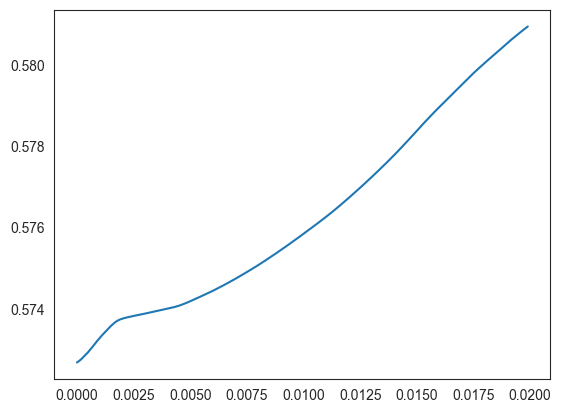

In [45]:
# Plot model performance as a function of alpha:
plt.plot(lasso_tune.alpha, lasso_tune.Score)
plt.show()
# What is the y-axis label? What is the x-axis label?

In [46]:
a1 = lasso_tune.alpha.iloc[lasso_tune['Score'].idxmin()]
a1

0.0

In [47]:
# Train model with optimal alpha1
model= Lasso(alpha=a1)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)

vif['LASSO_coef']= model.coef_

[-0.14694644  0.17578658  0.24906123  0.54799247  0.56568018  0.01516962
  0.05058612  0.30874658 -0.11700078  0.11409136]


/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/liamhawes/Documents/college/Senior Year/Python/TestPython/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.012e+02, tolerance: 3.108e-01 Linear regression models with null weight for the

### Penalized regression: elastic net penalty

In other words, the lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. The ridge penalty shrinks coefficients of collinear predictor variables nearer to each other, effectively partitioning the magnitude of response from the response variable between them, instead of "arbitrarily" partitioning it to one group.

We can also run a regression with a linear combination of ridge and lasso, called the elastic net, that has a cool property called "group selection."

The ridge penalty still works to distribute response variance equally between members of "groups" of collinear predictor variables. The lasso penalty still works to shrink certain coefficients to exactly zero so they can be ignored in model formulation. The elastic net produces models that are both sparse and stable under collinearity, by shrinking parameters of members of unimportant collinear predictor variables to exactly zero:

In [ ]:
# Explore the parameters in the ElasticNet fuction.
# Which variable represents the ridge coefficient? Which parameter represents the lasso coefficient?
?ElasticNet

In [48]:
# when L1 approaches infinity, certain coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = ElasticNet(alpha=.1, l1_ratio=.1)

In [49]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.584 (0.019)


In [50]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?
vif["ElNet_coef"]=model.coef_

[ 0.          0.00674673  0.          0.3051486   0.4025566   0.04906886
  0.05570949  0.25505486 -0.          0.07598362]


### TASK 12: Match these elastic net coefficients up with your original data. Do you see a logical grouping(s) between variables that have non-zero coefficients?


0.          0.00674673  0.          0.3051486   0.4025566   0.04906886   0.05570949  0.25505486 -0.          0.07598362]

There are zeros amoung one of the highly corlated variables

In [51]:
print(vif)

   VIF Factor    features  OLS_coef  Ridge_coef  LASSO_coef  ElNet_coef
0   36.733295  Demvotes16 -0.146946   -0.146946   -0.146946    0.000000
1   78.618563  total_2016  0.175787    0.175787    0.175787    0.006747
2   64.846395   RHI125214  0.249061    0.249061    0.249061    0.000000
3    3.545656   RHI225214  0.547992    0.547992    0.547992    0.305149
4   19.540259   EDU685213  0.565680    0.565680    0.565680    0.402557
5   16.434982   VET605213  0.015170    0.015170    0.015170    0.049069
6   10.425962   HSG495213  0.050586    0.050586    0.050586    0.055709
7   57.198577   HSD310213  0.308747    0.308747    0.308747    0.255055
8   62.978538   INC910213 -0.117001   -0.117001   -0.117001   -0.000000
9    1.703468   LND110210  0.114091    0.114091    0.114091    0.075984


## Extra Credit:
We saw how to tune individual parameters above. The elastic net regression here has two free parameters. How can you select the best values for these two free parameters?

Demonstrate in the cell below.

In [ ]:
# Extra credit scratch cell: